# What patterns exist between energy consumption and generation?

## Goals

By the end of this case, you will be even more familiar with using `pandas` for data transformation. You'll also gain experience with how to generate data visualizations like heat maps, line plots, strip plots, and box plots in Python. For these, you'll use the `matplotlib` and `seaborn` libraries.

## Inspecting the datasets

Let's start by importing our packages:

In [2]:
! pip install matplotlib

  Using cached matplotlib-3.4.2-cp38-cp38-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached Pillow-8.2.0-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
  Using cached kiwisolver-1.3.1-cp38-cp38-manylinux1_x86_64.whl (1.2 MB)


In [4]:
! pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Using cached scipy-1.6.3-cp38-cp38-manylinux1_x86_64.whl (27.2 MB)


In [5]:
# Load packages
import os
import pandas as pd
import numpy as np

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Advanced plotting functionality with seaborn
import seaborn as sns

sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

And now the CSV files:

In [6]:
# Load the data into python
energy_df = pd.read_csv("data/energy_consumption.csv")
electricity_df = pd.read_csv("data/electricity_generation.csv")

As usual, we take a look at the head of each dataset:

In [7]:
# Look at energy (consumption) data
energy_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,TXRCBUS,194913,4460.588,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
1,TXRCBUS,195013,4829.528,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
2,TXRCBUS,195113,5104.680,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
3,TXRCBUS,195213,5158.406,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
4,TXRCBUS,195313,5052.749,1,Primary Energy Consumed by the Residential Sector,Trillion Btu


In [8]:
# Look at electricity (generation) data
electricity_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLETPUS,194913,135451.32,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
1,CLETPUS,195013,154519.994,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
2,CLETPUS,195113,185203.657,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
3,CLETPUS,195213,195436.666,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
4,CLETPUS,195313,218846.325,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours


## Pre-processing data to simplify analysis moving forward

Data cleaning (i.e. data wrangling or data munging) is one of the most important first steps that you take when you analyze a dataset. Our energy dataset was not an exception to this. Recall what we had to do in lecture:

1. Remove missing values.
2. Shorten the descriptions.
3. Remove unnecessary columns.
4. Split the `YYYYMM` column.
5. Understand month 13 and remove it from the dataset.

Let's go over these one-by-one:

### Removing missing values

Before you remove missing values, you first need to detect them. The hint that made us realize we had missing data was that the `Value` column, instead of being of type `float64` as it would be logical, was of type `object`. That rose our suspicions, which were later confirmed when we found out that hidden amongst the numbers there was a string, `Not Available`, that made Python treat this numeric feature as a text feature.

To inspect the data types of a DataFrame, you can use the **`.dtypes`** attribute (it is not a method, so you don't add parenthesis):

In [9]:
electricity_df.dtypes

MSN             object
YYYYMM           int64
Value           object
Column_Order     int64
Description     object
Unit            object
dtype: object

A nifty hack to detect if a numeric column contains text is by sorting it. Here we use **`.sort_values()`**. Text values will then appear either at the top or the bottom of the sorted Series:

In [10]:
electricity_df["Value"].sort_values() # To Z-A sort, put ascending=False inside the parenthesis

7172           -0.001
7177           -0.004
7160           -0.009
6498           -0.016
6487           -0.069
            ...      
2116    Not Available
2115    Not Available
2114    Not Available
2094    Not Available
6418    Not Available
Name: Value, Length: 8216, dtype: object

There's definitely some text there!

Let's replace the `Not Available` string with a native missing value representation. Here we'll use `numpy`'s `np.nan`. (An even better option is `pandas`'s `pd.NA`, but this one only works in newer versions of `pandas`.) To replace values in a `pandas` Series, you use, quite unsurprisingly, the **`.replace()`** method (the first argument is the value you are replacing, and the second argument is the value you are replacing it with):

In [11]:
electricity_df["Value"] = electricity_df["Value"].replace("Not Available", np.nan)

### Finishing up with the `Value` column

Let's see if we succeeded. For this, we will use the **`.isna()`** and **`.value_counts()`** methods. `.isna()` creates a boolean Series in which there is a `True` if the corresponding value in `Value` is a `np.nan`, and a `False` otherwise. Then, `.value_counts()` counts the instances of `True` and `False` in that Boolean Series. This way, we can easily detect that there are 830 missing cells in our `Value` column:

In [12]:
electricity_df["Value"].isna().value_counts()

False    7386
True      830
Name: Value, dtype: int64

Now, we use the **`.dropna()`** method to remove all rows in which at least one entry is missing:

In [13]:
energy_df = energy_df.dropna()
electricity_df = electricity_df.dropna()

Finally, we convert `Value` to the `float64` data type, and we're done with our first task:

In [14]:
electricity_df["Value"] = electricity_df["Value"].astype(float)

In [15]:
electricity_df.dtypes

MSN              object
YYYYMM            int64
Value           float64
Column_Order      int64
Description      object
Unit             object
dtype: object

We've just introduced a lot of new methods! Let's take a moment to recap:

* `.dtypes` lets you access the data types of the columns of a DataFrame.
* `.sort_values()` sorts a Series.
* `.replace()` is used to replace values (including replacing strings with the `np.nan` missing value representation).
* `.isna()` and `.value_counts()` used together can tell us how many missing values we have in a Series.

### Renaming descriptions

Did you know that `.replace()` can also take dictionaries as input? This allows us to replace lots of `{original:replacement}` pairs with a single operation. 

### Example 1

Use the `.replace()` method with the below dictionaries to rename the values in the `Description` columns of `energy_df` and `electricity_df`.

In [16]:
energy_short_dict = {
    "Primary Energy Consumed by the Commercial Sector": "PEC Commercial Sector",
    "Primary Energy Consumed by the Electric Power Sector": "PEC Electric Power Sector",
    "Primary Energy Consumed by the Industrial Sector": "PEC Industrial Sector",
    "Primary Energy Consumed by the Residential Sector": "PEC Residential Sector",
    "Primary Energy Consumed by the Transportation Sector": "PEC Transportation Sector",
    "Primary Energy Consumption Total": "PEC Total",
    "Total Energy Consumed by the Commercial Sector": "TEC Commercial Sector",
    "Total Energy Consumed by the Industrial Sector": "TEC Industrial Sector",
    "Total Energy Consumed by the Residential Sector": "TEC Residential Sector",
    "Total Energy Consumed by the Transportation Sector": "TEC Transportation Sector",
}


electricity_short_dict = {
    "Electricity Net Generation From Coal, All Sectors": "ENG Coal",
    "Electricity Net Generation From Conventional Hydroelectric Power, All Sectors": "ENG HE Power",
    "Electricity Net Generation From Geothermal, All Sectors": "ENG Geothermal",
    "Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors": "ENG HE Pumped Storage",
    "Electricity Net Generation From Natural Gas, All Sectors": "ENG Natural Gas",
    "Electricity Net Generation From Nuclear Electric Power, All Sectors": "ENG Nuclear Electric Power",
    "Electricity Net Generation From Other Gases, All Sectors": "ENG Other Gases",
    "Electricity Net Generation From Petroleum, All Sectors": "ENG Petroleum",
    "Electricity Net Generation From Solar, All Sectors": "ENG Solar",
    "Electricity Net Generation From Waste, All Sectors": "ENG Waste",
    "Electricity Net Generation From Wind, All Sectors": "ENG Wind",
    "Electricity Net Generation From Wood, All Sectors": "ENG Wood",
    "Electricity Net Generation Total (including from sources not shown), All Sectors": "ENG Total",
}

**Answer.** Shown below:

In [17]:
energy_df["Description"] = energy_df["Description"].replace(energy_short_dict)
electricity_df["Description"] = electricity_df["Description"].replace(electricity_short_dict)

### Exercise 1

Create a replacement dictionary and then change `Trillion Btu` in `energy_df` for `Trillion British Thermal Units`.

**Answer.**

In [19]:
energy_df['Unit'].unique()

array(['Trillion Btu'], dtype=object)

In [22]:
TBU_dict = {"Trillion Btu": "Trillion British Thermal Units"}

In [25]:
energy_df["Unit"] = energy_df["Unit"].replace(TBU_dict)
energy_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,TXRCBUS,194913,4460.588,1,PEC Residential Sector,Trillion British Thermal Units
1,TXRCBUS,195013,4829.528,1,PEC Residential Sector,Trillion British Thermal Units
2,TXRCBUS,195113,5104.680,1,PEC Residential Sector,Trillion British Thermal Units
3,TXRCBUS,195213,5158.406,1,PEC Residential Sector,Trillion British Thermal Units
4,TXRCBUS,195313,5052.749,1,PEC Residential Sector,Trillion British Thermal Units


-------

### Removing unnecessary columns

This one is even easier than the previous two. To drop a column from a DataFrame, you use the **`.drop()`** method:

In [26]:
energy_df = energy_df.drop(columns=["MSN", "Column_Order"])
electricity_df = electricity_df.drop(columns=["MSN", "Column_Order"])

# Making sure it worked -- hooray!
energy_df.head()

,YYYYMM,Value,Description,Unit
0,194913,4460.588,PEC Residential Sector,Trillion British Thermal Units
1,195013,4829.528,PEC Residential Sector,Trillion British Thermal Units
2,195113,5104.680,PEC Residential Sector,Trillion British Thermal Units
3,195213,5158.406,PEC Residential Sector,Trillion British Thermal Units
4,195313,5052.749,PEC Residential Sector,Trillion British Thermal Units


### Splitting the `YYYYMM` column

Sometimes you have IDs or dates in a format that contains valuable but disparate bits of information squeezed together as a single string. For instance:

* `FordMustang2019`. This contains three features: `Ford` (make), `Mustang` (model), and `2019` (year).
* `SamsungGalaxy`. This has two: `Samsung` (make) and `Galaxy` (model).
* `199901`. Here we have a year (`1999`) and a month (`01`). This is what we have in this dataset.

One clever way to separate the features is by using string methods in `pandas`. You access them appending `.str` to the Series and then calling the method as such. In this case, we want to split `199901` into `1999` and `01`, so one good strategy would be to split the string right after the fourth character. You might remember from a previous case that if you want to take the first 4 characters of a string, you can slice it with `[0:4]`. Let's do that and get the years (we had first to convert `YYYYMM` into a string column because it was originally stored as an integer column):

In [27]:
energy_df["YYYYMM"] = energy_df["YYYYMM"].astype(str)
energy_df["YYYY"] = energy_df["YYYYMM"].str[0:4] # Notice that we wrote .str before slicing
energy_df.head()

,YYYYMM,Value,Description,Unit,YYYY
0,194913,4460.588,PEC Residential Sector,Trillion British Thermal Units,1949
1,195013,4829.528,PEC Residential Sector,Trillion British Thermal Units,1950
2,195113,5104.680,PEC Residential Sector,Trillion British Thermal Units,1951
3,195213,5158.406,PEC Residential Sector,Trillion British Thermal Units,1952
4,195313,5052.749,PEC Residential Sector,Trillion British Thermal Units,1953


Let's do the same for the `electricity_df` DataFrame:

In [28]:
electricity_df["YYYYMM"] = electricity_df["YYYYMM"].astype(str)
electricity_df["YYYY"] = electricity_df["YYYYMM"].str[0:4]

### Exercise 2

Get the months and add them to both DataFrames as the `MM` column.

**Hint:** You can use [negative slicing with strings](https://www.w3schools.com/python/gloss_python_string_negative_indexing.asp) as well!

**Answer.** Shown below:

In [29]:
energy_df["MM"] = energy_df["YYYYMM"].str[-2:]
electricity_df["MM"] = electricity_df["YYYYMM"].str[-2:]

energy_df.head()

,YYYYMM,Value,Description,Unit,YYYY,MM
0,194913,4460.588,PEC Residential Sector,Trillion British Thermal Units,1949,13
1,195013,4829.528,PEC Residential Sector,Trillion British Thermal Units,1950,13
2,195113,5104.680,PEC Residential Sector,Trillion British Thermal Units,1951,13
3,195213,5158.406,PEC Residential Sector,Trillion British Thermal Units,1952,13
4,195313,5052.749,PEC Residential Sector,Trillion British Thermal Units,1953,13


Let's now remove the month 13 rows, since those are simply the sum of all the other values for each year. We can take advantage of the `.drop()` method again, because not only it can drop columns, it can also drop rows:

In [30]:
dropme_energy = energy_df["MM"]=="13" # We filter the rows with month 13
energy_df = energy_df.drop(energy_df[dropme_energy].index)
energy_df.head()

,YYYYMM,Value,Description,Unit,YYYY,MM
24,197301,1339.270,PEC Residential Sector,Trillion British Thermal Units,1973,01
25,197302,1174.899,PEC Residential Sector,Trillion British Thermal Units,1973,02
26,197303,983.374,PEC Residential Sector,Trillion British Thermal Units,1973,03
27,197304,715.391,PEC Residential Sector,Trillion British Thermal Units,1973,04
28,197305,535.914,PEC Residential Sector,Trillion British Thermal Units,1973,05


Here, we first defined the condition `dropme_energy`, which is a Boolean Series. Then we filtered our DataFrame according to that condition and extracted the indices of the rows that we wanted to remove. We did that with `energy_df[dropme_energy].index`. And finally, we passed those indices to the `.drop()` function.

We now do the same with the `electricity_df` DataFrame:

In [31]:
dropme_electricity = electricity_df["MM"]=="13" # We filter the rows with month 13
electricity_df = electricity_df.drop(electricity_df[dropme_electricity].index)
electricity_df.head()

,YYYYMM,Value,Description,Unit,YYYY,MM
24,197301,75190.149,ENG Coal,Million Kilowatthours,1973,01
25,197302,67797.946,ENG Coal,Million Kilowatthours,1973,02
26,197303,67387.612,ENG Coal,Million Kilowatthours,1973,03
27,197304,63935.049,ENG Coal,Million Kilowatthours,1973,04
28,197305,64927.181,ENG Coal,Million Kilowatthours,1973,05


## Identifying the relationship between energy consumption and generation

Here's how to make the `PEC Electric Power Sector` vs. `ENG Nuclear Electric Power` scatterplot using `matplotlib`. First, we filter the DataFrames to keep only the rows we need:

In [32]:
# Filtering the DataFrames
consume_df = energy_df[energy_df["Description"] == "PEC Electric Power Sector"]
generate_df = electricity_df[electricity_df["Description"] == "ENG Nuclear Electric Power"]

# Getting rid of unnecesary columns
consume_df = consume_df.drop(columns=["Description", "Unit", "YYYY", "MM"])
generate_df = generate_df.drop(columns=["Description", "Unit", "YYYY", "MM"])

Then, we merge the DataFrames using the **`pd.merge()`** function. To join two DataFrames this way, there has to be a column with common values in both (this column is called the **join key**). Our datasets have all their columns in common, but the one we will use is `YYYYMM` because in order to make our scatterplot we need both datasets to be aligned by their dates:

In [33]:
merged_df = pd.merge(consume_df, generate_df, on="YYYYMM")
merged_df.head()

,YYYYMM,Value_x,Value_y
0,197301,1691.096,6246.251
1,197302,1511.458,5928.069
2,197303,1559.159,6649.007
3,197304,1470.152,5876.392
4,197305,1551.631,5696.657


As you see, we got two `Value` columns , but we don't know which one is consumption and which one is generation. To fix this, we use the `suffixes` argument:

In [34]:
merged_df = pd.merge(consume_df, generate_df, on="YYYYMM", suffixes=["_CONSUME", "_GENERATE"])
merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE
0,197301,1691.096,6246.251
1,197302,1511.458,5928.069
2,197303,1559.159,6649.007
3,197304,1470.152,5876.392
4,197305,1551.631,5696.657


This is the code to make the plot (`plt` is the alias we used to import `matplotlib`'s plotting module):

Text(0, 0.5, 'PEC Electric Power Sector')

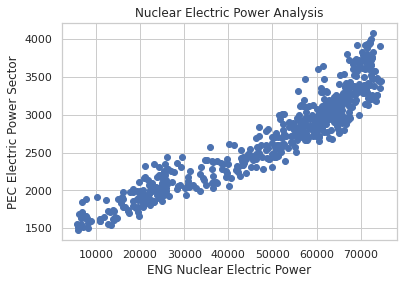

In [35]:
plt.scatter(x = merged_df["Value_GENERATE"], y = merged_df["Value_CONSUME"]) # The plot
plt.title("Nuclear Electric Power Analysis") # Adding a title
plt.xlabel("ENG Nuclear Electric Power") # Adding axis labels
plt.ylabel("PEC Electric Power Sector")

#### A word about `pd.merge()`

The `pd.merge()` function will definitely be one the most important elements in your toolbox in the future, so it makes sense that we explain it a little more here. When you merge two DataFrames you are joining them by their shared key. There are four main kinds of merge operations in `pandas`: left joins, right joins, inner joins, and full joins. Let's explain them graphically.

This will be our `left` DataFrame (we called it `L`):

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>has_tickets</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>IBV2750</td>      <td>True</td>    </tr>    <tr>      <th>1</th>      <td>EUS687</td>      <td>False</td>    </tr>    <tr>      <th>2</th>      <td>AYE7756</td>      <td>True</td>    </tr>  </tbody></table>

And this will be our `right` DataFrame (`R`):

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>owners_name</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>6TRJ244</td>      <td>Michael Holmes</td>    </tr>    <tr>      <th>1</th>      <td>EUS687</td>      <td>Jenny Liu</td>    </tr>    <tr>      <th>2</th>      <td>532484</td>      <td>Geoffrey Frank</td>    </tr>  </tbody></table>

##### Left join

Arguably the most common way of merging DataFrames is using a **left join**, that graphically looks like this:
~~~python
pd.merge(L, R, on="number_plate", how="left")
~~~

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>has_tickets</th>      <th>owners_name</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>IBV2750</td>      <td>True</td>      <td>NaN</td>    </tr>    <tr>      <th>1</th>      <td>EUS687</td>      <td>False</td>      <td>Jenny Liu</td>    </tr>    <tr>      <th>2</th>      <td>AYE7756</td>      <td>True</td>      <td>NaN</td>    </tr>  </tbody></table>

Here we took all the elements of the `left` DataFrame and tried to find a match in the `right` DataFrame for each one of them. Then we reported all the elements of the `left` DataFrame regardless of whether we did find a match or not. In this case, the only car that had a match was `EUS687` and hence it is the only one that has an associated `owners_name` in the result.

##### Right join

This is exactly the same as the left join, with the difference that we report all the elements of the `right` DataFrame instead of those of the `left` DataFrame:

~~~python
pd.merge(L, R, on="number_plate", how="right")
~~~

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>has_tickets</th>      <th>owners_name</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>6TRJ244</td>      <td>NaN</td>      <td>Michael Holmes</td>    </tr>    <tr>      <th>1</th>      <td>EUS687</td>      <td>False</td>      <td>Jenny Liu</td>    </tr>    <tr>      <th>2</th>      <td>532484</td>      <td>NaN</td>      <td>Geoffrey Frank</td>    </tr>  </tbody></table>

This would be equivalent to `pd.merge(R, L, on="number_plate", how="left")` (notice that we swapped the DataFrames).

##### Inner join

This kind of join only reports those elements that are both in the `right` and the `left` DataFrames:

~~~python
pd.merge(L, R, on="number_plate", how="inner")
~~~

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>has_tickets</th>      <th>owners_name</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>EUS687</td>      <td>False</td>      <td>Jenny Liu</td>    </tr>  </tbody></table>

##### Full join

Finally, a **full join** reports all the elements of both DataFrames, including those that had a match and those that did not:

~~~python
pd.merge(L, R, on="number_plate", how="outer")
~~~

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>number_plate</th>      <th>has_tickets</th>      <th>owners_name</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>IBV2750</td>      <td>True</td>      <td>NaN</td>    </tr>    <tr>      <th>1</th>      <td>EUS687</td>      <td>False</td>      <td>Jenny Liu</td>    </tr>    <tr>      <th>2</th>      <td>AYE7756</td>      <td>True</td>      <td>NaN</td>    </tr>    <tr>      <th>3</th>      <td>6TRJ244</td>      <td>NaN</td>      <td>Michael Holmes</td>    </tr>    <tr>      <th>4</th>      <td>532484</td>      <td>NaN</td>      <td>Geoffrey Frank</td>    </tr>  </tbody></table>

Keep in mind that the keyword for a full join in `pandas` is not ~`full`~ but `outer`. This is because "full join" is a shortened form of "full outer join".

### Exercise 3

Copy the code of the previous cells and paste it below. Then modify it to make a scatterplot of `PEC Commercial Sector` vs. `ENG Nuclear Electric Power` this time.

**Answer.**

In [37]:
# Filtering the DataFrames
consume_df = energy_df[energy_df["Description"] == "PEC Commercial Sector"]
generate_df = electricity_df[electricity_df["Description"] == "ENG Nuclear Electric Power"]

# Getting rid of unnecesary columns
consume_df = consume_df.drop(columns=["Description", "Unit", "YYYY", "MM"])
generate_df = generate_df.drop(columns=["Description", "Unit", "YYYY", "MM"])

In [38]:
merged_df = pd.merge(consume_df, generate_df, on="YYYYMM")
merged_df.head()

,YYYYMM,Value_x,Value_y
0,197301,657.977,6246.251
1,197302,623.759,5928.069
2,197303,492.136,6649.007
3,197304,363.393,5876.392
4,197305,288.630,5696.657


In [39]:
merged_df = pd.merge(consume_df, generate_df, on="YYYYMM", suffixes=["_CONSUME", "_GENERATE"])
merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE
0,197301,657.977,6246.251
1,197302,623.759,5928.069
2,197303,492.136,6649.007
3,197304,363.393,5876.392
4,197305,288.630,5696.657


Text(0, 0.5, 'PEC Commercial Sector')

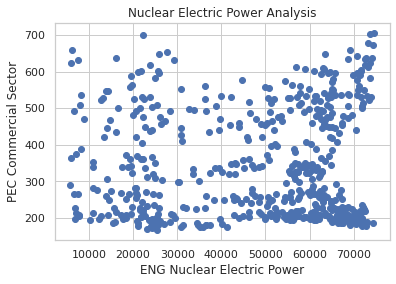

In [40]:
plt.scatter(x = merged_df["Value_GENERATE"], y = merged_df["Value_CONSUME"]) # The plot
plt.title("Nuclear Electric Power Analysis") # Adding a title
plt.xlabel("ENG Nuclear Electric Power") # Adding axis labels
plt.ylabel("PEC Commercial Sector")

-------

## Trends in energy consumption and generation over time

While a scatterplot helps us visualize the relationship between two variables, it does not allow us to look at something across time. For this, we will use the line plot. A line plot is excellent for viewing time series data and will help us determine trends and cyclical patterns across time for both electric power sector energy consumption and nuclear electric power energy generation.

Let's build a line plot for the `PEC Electric Power Sector` description:

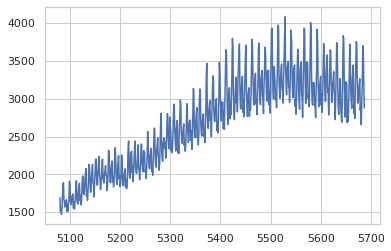

In [41]:
# Filtering the DataFrame
consume_df = energy_df[energy_df["Description"] == "PEC Electric Power Sector"].copy()
plt.plot(consume_df["Value"]) # plt.plot is the matplotlib function to draw line plots

This plot looks okay, but the horizontal axis is not very meaningful. Its labels are numbers that don't seem to be dates. A quick inspection of our data reveals that these are simply the row indices of the DataFrame:

In [42]:
consume_df.head()

,YYYYMM,Value,Description,Unit,YYYY,MM
5080,197301,1691.096,PEC Electric Power Sector,Trillion British Thermal Units,1973,01
5081,197302,1511.458,PEC Electric Power Sector,Trillion British Thermal Units,1973,02
5082,197303,1559.159,PEC Electric Power Sector,Trillion British Thermal Units,1973,03
5083,197304,1470.152,PEC Electric Power Sector,Trillion British Thermal Units,1973,04
5084,197305,1551.631,PEC Electric Power Sector,Trillion British Thermal Units,1973,05


In order to put the dates on the horizontal axis, we need to convert the `YYYYMM` column to `pandas`'s native `datetime` data type. We've done this before in another case, but here's again how to do it:

In [43]:
converted_date = pd.to_datetime(consume_df["YYYYMM"], format="%Y%m")
consume_df["Date"] = converted_date
consume_df.head()

,YYYYMM,Value,Description,Unit,YYYY,MM,Date
5080,197301,1691.096,PEC Electric Power Sector,Trillion British Thermal Units,1973,01,1973-01-01
5081,197302,1511.458,PEC Electric Power Sector,Trillion British Thermal Units,1973,02,1973-02-01
5082,197303,1559.159,PEC Electric Power Sector,Trillion British Thermal Units,1973,03,1973-03-01
5083,197304,1470.152,PEC Electric Power Sector,Trillion British Thermal Units,1973,04,1973-04-01
5084,197305,1551.631,PEC Electric Power Sector,Trillion British Thermal Units,1973,05,1973-05-01


Let's explain what we've just done. First, we used `pd.to_datetime()` to convert `consume_df["YYYYMM"]` into the `datetime` type. The `format="%Y%m"` argument is simply telling `pandas` that the `YYYYMM` column starts with the year (the `%Y` part) and then has the month (the `%m` part), and does not include information about the day.

Now equipped with our newly created `Date` column, we can remake the plot and add a title and axis labels:

Text(0, 0.5, 'Value - PEC Electric Power Sector')

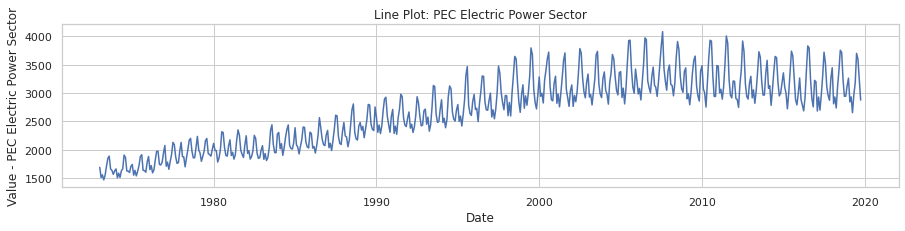

In [44]:
plt.figure(figsize=(15, 3)) # To make it larger
plt.plot(consume_df["Date"], consume_df["Value"]) # The order is plt.plot(x,y)
plt.title("Line Plot: PEC Electric Power Sector")
plt.xlabel("Date")
plt.ylabel("Value - PEC Electric Power Sector")

### Exercise 4

Repeat the steps above, but make a line plot of `ENG Nuclear Electric Power` instead.

**Hint:** Here's the first line of the answer to help you get started:

~~~python
generate_df = electricity_df[electricity_df["Description"] == "ENG Nuclear Electric Power"]
~~~

**Answer.**

Text(0, 0.5, 'Value - ENG Nuclear Electric Power')

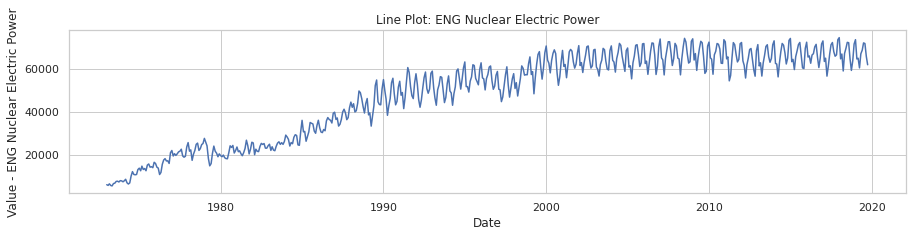

In [60]:
# Filtering the DataFrames
generate_df = electricity_df[electricity_df["Description"] == "ENG Nuclear Electric Power"].copy()
converted_date = pd.to_datetime(generate_df["YYYYMM"], format="%Y%m")
generate_df["Date"] = converted_date
plt.figure(figsize=(15, 3)) # To make it larger
plt.plot(generate_df["Date"], generate_df["Value"]) # The order is plt.plot(x,y)
plt.title("Line Plot: ENG Nuclear Electric Power")
plt.xlabel("Date")
plt.ylabel("Value - ENG Nuclear Electric Power")

-------

To wrap up this section, let's make a plot of percentage variations. For that, we will use the handy [**`.pct_change()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) Series method:

Text(0, 0.5, 'ENG Nuclear Electric Power (% change)')

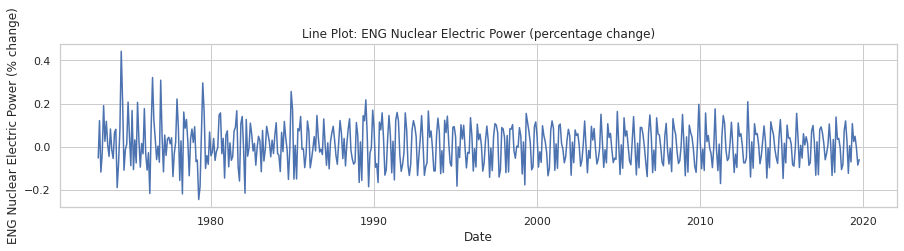

In [61]:
plt.figure(figsize=(15, 3)) # To make it larger
plt.plot(generate_df["Date"], generate_df["Value"].pct_change())
plt.title("Line Plot: ENG Nuclear Electric Power (percentage change)")
plt.xlabel("Date")
plt.ylabel("ENG Nuclear Electric Power (% change)")

## Using ```seaborn```


While ```matplotlib``` is a nice plotting package, it is meant to be a general plotting tool. ```seaborn``` is an extremely useful data visualization library specifically designed for statistical figures. We will go through some important plotting functionality while continuing to identify trends in the energy data. We will only be scratching the surface of ```seaborn```, but [here](https://seaborn.pydata.org/api.html) is a list of all the possible plots.

### Heat maps

Let's now look at consumption and generation levels month-by-month over time to see if the peak cyclical patterns we see are stable across many decades of data.

```seaborn``` offers the powerful heat map method [**```heatmap()```**](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap) that will allow us to nicely visualize the monthly energy consumed and electricity generated over time. Before we use it, let's first create a pivot table as usual:

In [53]:
pivoted_df = pd.pivot_table(data=generate_df, index="MM", columns="YYYY", values="Value")
pivoted_df

YYYY,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
MM,,,,,,,,,,,,,,,,,,,,,
01,6246.251,7602.790,13938.354,16098.884,22152.064,25832.949,27792.163,19745.966,23778.769,25677.834,...,72569.341,72742.813,72381.186,71405.817,73162.609,74269.974,72524.775,73120.612,74649.040,73700.844
02,5928.069,8115.522,12733.338,14377.127,19600.518,21832.500,25910.788,19277.338,21595.261,20187.619,...,65245.370,64789.078,63847.023,61483.385,62638.950,63461.493,65638.141,63560.371,64790.030,64714.894
03,6649.007,8777.497,14881.784,13992.977,20672.203,22448.665,24334.822,20038.872,22004.399,22755.478,...,64634.721,65661.598,61728.613,62947.389,62397.080,64546.799,66148.894,65093.200,67032.656,65079.691
04,5876.392,7128.892,13327.245,10981.808,19866.564,17579.902,18417.942,18793.503,20646.019,21784.661,...,57611.073,54547.338,55870.931,56766.882,56384.588,59784.495,62731.845,56743.352,59133.155,60580.927
05,5696.657,6562.335,13763.765,11929.390,20599.284,20416.170,15024.851,18384.807,19723.090,21638.768,...,66658.365,57012.914,62081.445,62848.155,62947.430,65826.525,66576.493,61312.753,67320.248,67123.546
06,6784.152,7079.595,12743.820,15757.435,21517.301,22185.187,16065.455,18322.206,21165.626,24026.011,...,68301.322,65270.134,65140.085,66429.690,68138.232,68516.165,67175.324,67010.782,69687.556,68804.879
07,6960.486,10209.908,15372.216,17708.727,21824.835,25007.094,20824.729,21023.937,23079.647,25467.060,...,71913.468,72344.850,69129.329,70539.238,71940.126,71412.176,70349.347,71314.219,72456.009,72198.595
08,7785.326,12333.452,15879.687,18362.580,22749.668,25599.306,24204.083,24332.931,26946.387,24986.071,...,71574.103,71338.566,69602.111,71344.379,71128.746,72415.352,71526.405,72384.218,72282.467,71910.684
09,7862.383,11009.752,14396.011,17290.311,19629.992,22188.917,21803.870,23572.294,24398.455,25390.532,...,69371.195,66848.854,64510.882,65798.971,67534.500,66476.372,65448.176,68097.918,64724.753,65892.180


Now it's simply a matter of using `sns.heatmap()`. You can customize the plot (like setting its size and adding a title and axis labels) using `matplotlib` just as with the previous plots, because `seaborn` is built on top of `matplotlib`:

<AxesSubplot:xlabel='YYYY', ylabel='MM'>

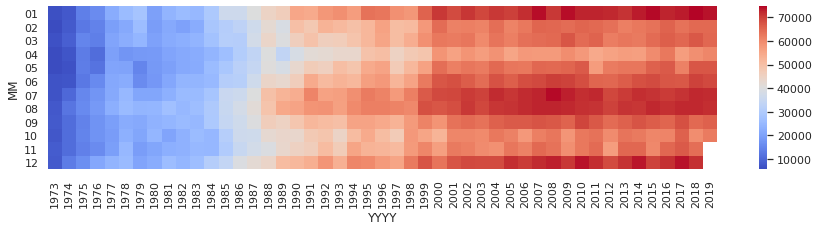

In [54]:
plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df, cmap="coolwarm") # cmap defines the color palette

### Box plots

We can create box plots just as easily with the `sns.boxplot()` function. In the cell below, we ask `seaborn` to group our data by `Description` (the x-axis) and plot the distribution of `Value` for each `Description`. The `plt.xticks(rotation=90)` line is a bit of `matplotlib` code that rotates the x-axis labels by 90 degrees to prevent label collisions:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'PEC Residential Sector'),
  Text(1, 0, 'TEC Residential Sector'),
  Text(2, 0, 'PEC Commercial Sector'),
  Text(3, 0, 'TEC Commercial Sector'),
  Text(4, 0, 'PEC Industrial Sector'),
  Text(5, 0, 'TEC Industrial Sector'),
  Text(6, 0, 'PEC Transportation Sector'),
  Text(7, 0, 'TEC Transportation Sector'),
  Text(8, 0, 'PEC Electric Power Sector'),
  Text(9, 0, 'Energy Consumption Balancing Item'),
  Text(10, 0, 'PEC Total')])

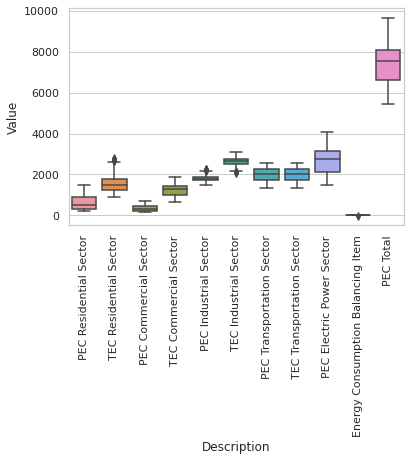

In [55]:
sns.boxplot(x="Description", y="Value", data=energy_df)
plt.xticks(rotation=90)

The size of some `seaborn` plots won't be affected by `plt.figure(figsize=())`. This is the case for box plots - the syntax is just slightly different:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'PEC Residential Sector'),
  Text(1, 0, 'TEC Residential Sector'),
  Text(2, 0, 'PEC Commercial Sector'),
  Text(3, 0, 'TEC Commercial Sector'),
  Text(4, 0, 'PEC Industrial Sector'),
  Text(5, 0, 'TEC Industrial Sector'),
  Text(6, 0, 'PEC Transportation Sector'),
  Text(7, 0, 'TEC Transportation Sector'),
  Text(8, 0, 'PEC Electric Power Sector'),
  Text(9, 0, 'Energy Consumption Balancing Item'),
  Text(10, 0, 'PEC Total')])

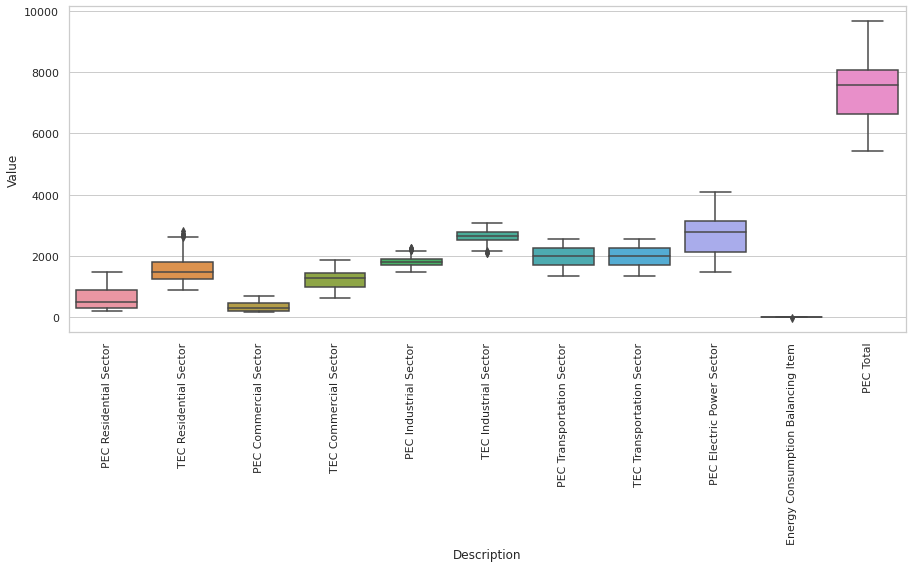

In [56]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x="Description", y="Value", data=energy_df, ax=ax)
plt.xticks(rotation=90)

### Strip plots

### Exercise 5 (optional)

Making strip plots is very easy - you use `sns.stripplot()`. Copy the previous code cell and modify it to make a strip plot instead of a box plot.

**Answer.**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'PEC Residential Sector'),
  Text(1, 0, 'TEC Residential Sector'),
  Text(2, 0, 'PEC Commercial Sector'),
  Text(3, 0, 'TEC Commercial Sector'),
  Text(4, 0, 'PEC Industrial Sector'),
  Text(5, 0, 'TEC Industrial Sector'),
  Text(6, 0, 'PEC Transportation Sector'),
  Text(7, 0, 'TEC Transportation Sector'),
  Text(8, 0, 'PEC Electric Power Sector'),
  Text(9, 0, 'Energy Consumption Balancing Item'),
  Text(10, 0, 'PEC Total')])

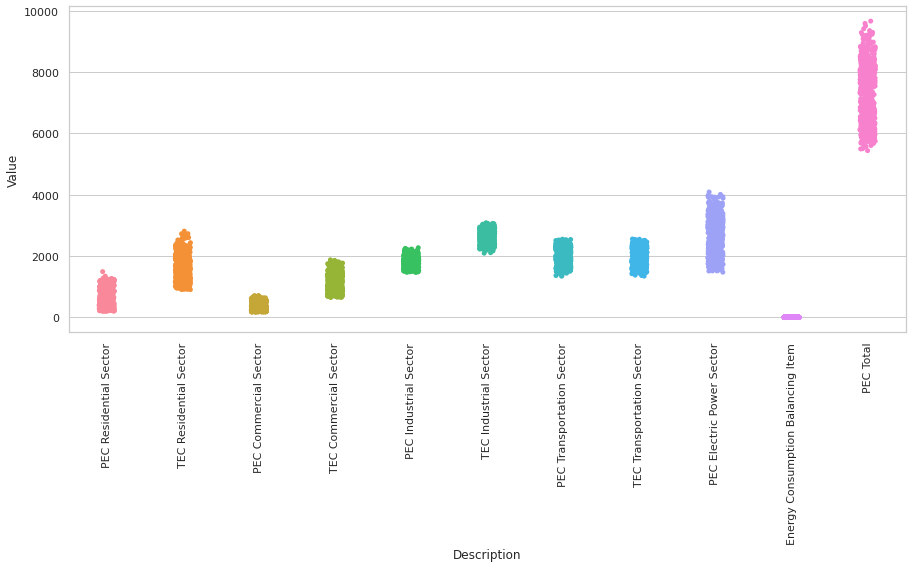

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
sns.stripplot(x="Description", y="Value", data=energy_df, ax=ax)
plt.xticks(rotation=90)

-------

## Appendix

Here is a summary of the functions and tools introduced in this workshop:

* `pandas` data exploration functions 
    * [`dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html): This is an attribute of `pandas` DataFrames that tells you the data types of the columns of the DataFrame. We don't use parenthesis when we access it.
    * [`.isna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html): When you call this function on a DataFrame or Series, it outputs a boolean object whose values are `True` if the corresponding value in the DataFrame is a null value, and `False` otherwise.
    * [`.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html): This Series method creates a frequency table of the values in a Series.
* `pandas` data transformation functions
    * [`.drop()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html): Drops either columns or rows in a DataFrame. To drop columns, you pass the `columns` argument and a list of the columns you want to remove. To drop rows, you do the same, only using the argument `index` instead.
    * [`.dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html): This method finds all the rows in a DataFrame or Series that contain null fields and removes them. If you call it on a DataFrame, you can optionally specify which columns to look for null values in, so that null values in other columns are allowed (for this, you use the `subset` argument).
    * `.pct_change()`: This method computes the percentage change in a Series, comparing each item with the previous one (other lags are [possible](https://pandas.pydata.org/docs/reference/api/pandas.Series.pct_change.html)).
    * [`.replace()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html): Call this method to replace values in a DataFrame or Series. You can pass a dictionary.
    * [`.sort_values()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html): To sort a DataFrame or Series. You use `by` to tell `pandas` which column you would like to sort by, and to do a Z-A sort (or, equivalently, a 9-0 sort) you pass `ascending=False`.
* `seaborn` plotting functions
    * [`.boxplot()`](https://seaborn.pydata.org/generated/seaborn.boxplot.html) for box plots
    * [`.heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for heat maps
    * [`.stripplot()`](https://seaborn.pydata.org/generated/seaborn.stripplot.html) for strip plots